<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Statsmodels.api" data-toc-modified-id="Statsmodels.api-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statsmodels.api</a></span></li><li><span><a href="#PyMC" data-toc-modified-id="PyMC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyMC</a></span><ul class="toc-item"><li><span><a href="#Approach-1:-Base-PyMC,-Gaussian-Random-Walk" data-toc-modified-id="Approach-1:-Base-PyMC,-Gaussian-Random-Walk-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Approach 1: Base PyMC, Gaussian Random Walk</a></span></li><li><span><a href="#PyMC-StateSpace-Implementation" data-toc-modified-id="PyMC-StateSpace-Implementation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PyMC StateSpace Implementation</a></span><ul class="toc-item"><li><span><a href="#Model" data-toc-modified-id="Model-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Priors</a></span><ul class="toc-item"><li><span><a href="#Unconditional-Prior" data-toc-modified-id="Unconditional-Prior-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Unconditional Prior</a></span></li><li><span><a href="#Conditional-Prior" data-toc-modified-id="Conditional-Prior-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Conditional Prior</a></span></li></ul></li><li><span><a href="#Posterior" data-toc-modified-id="Posterior-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Posterior</a></span><ul class="toc-item"><li><span><a href="#Conditional-Posterior" data-toc-modified-id="Conditional-Posterior-3.2.3.1"><span class="toc-item-num">3.2.3.1&nbsp;&nbsp;</span>Conditional Posterior</a></span></li><li><span><a href="#Unconditional-Posterior" data-toc-modified-id="Unconditional-Posterior-3.2.3.2"><span class="toc-item-num">3.2.3.2&nbsp;&nbsp;</span>Unconditional Posterior</a></span></li></ul></li></ul></li><li><span><a href="#Outputs-Compared" data-toc-modified-id="Outputs-Compared-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Outputs Compared</a></span></li><li><span><a href="#Smoother-Outputs-from-all-3-models" data-toc-modified-id="Smoother-Outputs-from-all-3-models-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Smoother Outputs from all 3 models</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline

import pymc as pm
import aesara
from aesara import tensor as at

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, linalg

import time

config = {
    "figure.figsize": (12, 4),
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable efl


# Data

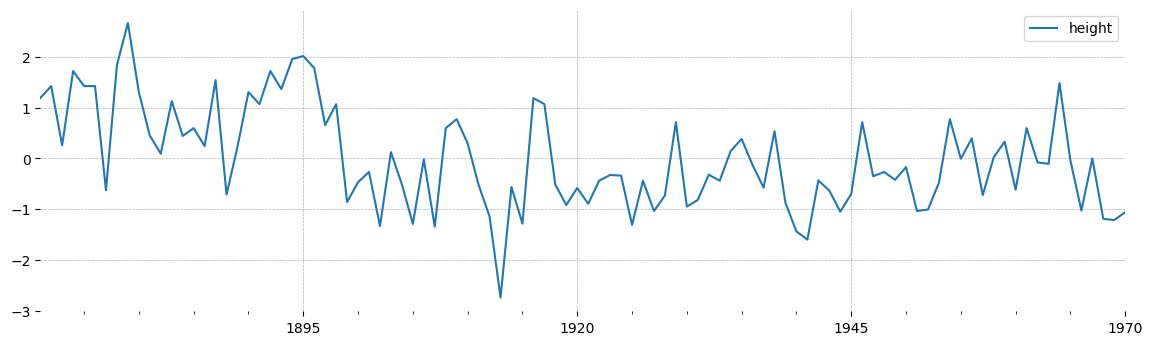

In [2]:
nile = pd.read_csv("data/nile.csv")
nile.index = pd.date_range(start="1871-01-01", end="1970-01-01", freq="AS-Jan")
nile.rename(columns={"x": "height"}, inplace=True)

nile = (nile - nile.mean()) / nile.std()
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
nile.plot(ax=ax)
plt.show()

# Statsmodels.api 

In [3]:
from tests.statsmodel_local_level import LocalLinearTrend

In [4]:
nile_ml = LocalLinearTrend(nile, initialization="approximate_diffuse")
res = nile_ml.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:               LocalLinearTrend   Log Likelihood                -142.664
Date:                Sat, 11 Jun 2022   AIC                            291.329
Time:                        20:38:27   BIC                            299.144
Sample:                    01-01-1871   HQIC                           294.492
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level           0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend        1.085e-11      0.000   7.38e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.30   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                             0.05
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
ml_point_estimates = res.params.values

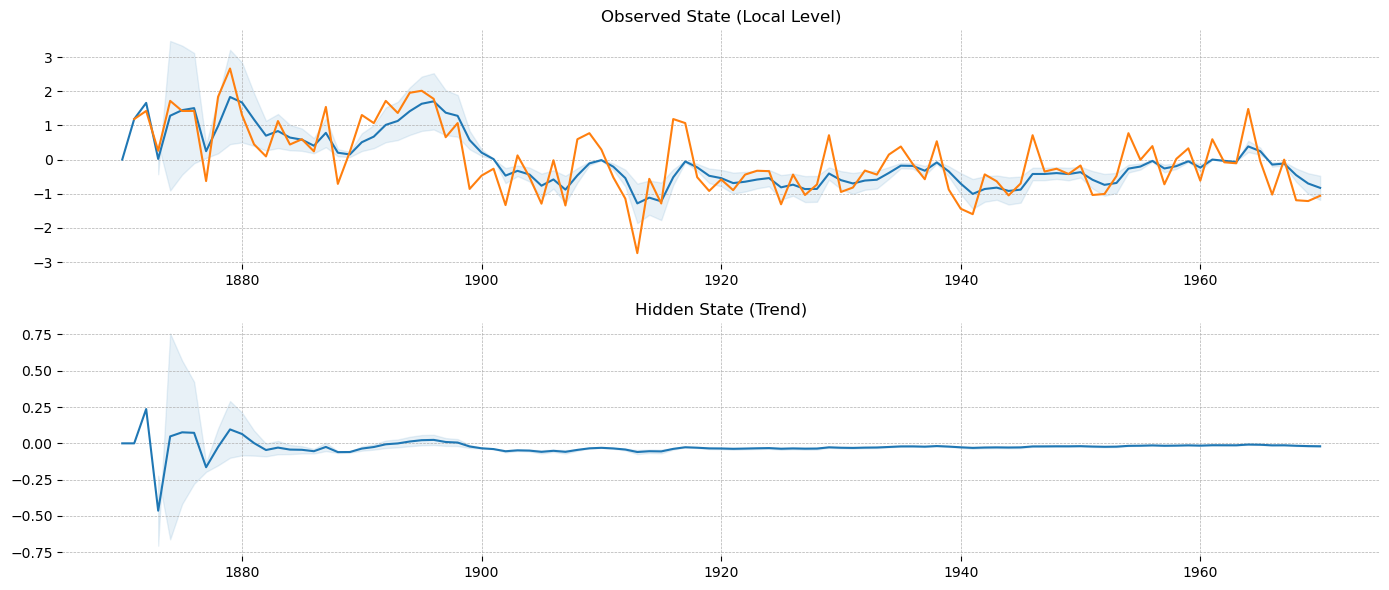

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=100)
x_values = nile.index
x_values_plus = pd.date_range(start="1870-01-01", end="1970-01-01", freq="AS-Jan")

state_mean = res.states.predicted.values
state_cov = res.states.predicted_cov.values.reshape(101, 2, 2)
ci_bounds = 1.96 * np.einsum("tk,tkj->tj", state_mean, state_cov)

upper = state_mean + ci_bounds
lower = state_mean - ci_bounds


ax[0].plot(x_values_plus, state_mean[:, 0])
ax[0].fill_between(x_values[2:], y1=lower[3:, 0], y2=upper[3:, 0], color="tab:blue", alpha=0.1)

ax[0].plot(x_values, nile.values)
ax[0].set(title="Observed State (Local Level)")

ax[1].plot(x_values_plus, state_mean[:, 1])
ax[1].fill_between(x_values[2:], y1=lower[3:, 1], y2=upper[3:, 1], color="tab:blue", alpha=0.1)

ax[1].set(title="Hidden State (Trend)")

fig.tight_layout()
plt.show()

# PyMC

## Approach 1: Base PyMC, Gaussian Random Walk

Thanks to @DanWeitzenfeld who showed me this implementation here: https://gist.github.com/DanielWeitzenfeld/1396dc9a1f4681dbff5e9d7fb19ccf25++. 

This is a very clean way to do a Local Level model, and it samples very fast.

In [7]:
coords = {"time": nile.index.year.values, "states": ["level", "trend"], "obs": ["nile"]}
n_obs = nile.shape[0]
with pm.Model() as model:

    sigma_mu = pm.HalfNormal("sigma_mu", sigma=1.0)
    mu = pm.Normal("mu", mu=0, sigma=sigma_mu, shape=n_obs).cumsum()

    sigma_obs = pm.HalfNormal("sigma_obs", 1.0)
    obs = pm.Normal("obs", mu=mu, sigma=sigma_obs, observed=nile.height)

    grw_trace = pm.sample(target_accept=0.95, init="jitter+adapt_diag_grad")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_mu, mu, sigma_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


Estimated parameters are far from the Kalman filter estimates. I don't know why; need to think about the underlying math. It is missing the hidden trend state because it is folded into the GRW, which means some of the variance that is assigned to fluctuation in the trend state is instead put into the level state? 

There might be a direct equalivance between the two models that would allow us to recover parameter estimates for one from the other. Not sure.

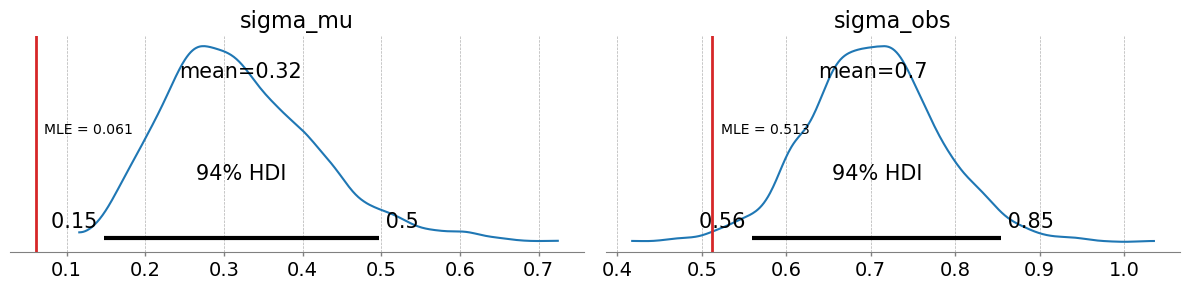

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=100)
az.plot_posterior(grw_trace, var_names=["sigma_mu", "sigma_obs"], ax=ax)
params = ["sigma2.level", "sigma2.measurement"]
for axis, name in zip(fig.axes, params):
    axis.axvline(res.params[name], color="tab:red", lw=2)
    ymin, ymax = axis.get_ylim()
    midpoint = (ymax - ymin) / 2
    axis.annotate(xy=(res.params[name] + 0.01, midpoint), text=f"MLE = {res.params[name]:0.3f}")

fig.tight_layout()
plt.show()

In [9]:
with model:
    grw_post = pm.sample_posterior_predictive(grw_trace)

Note the ESS. The sampler has a hard time with this model, I assume because of the huge number of nusicance parameters (100 mus!). This likely only gets worse as you add additional hidden states. We can do better!

In [10]:
az.summary(grw_trace, var_names=["sigma_mu", "sigma_obs"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_mu   0.321  0.097   0.148    0.497      0.009    0.007     107.0   
sigma_obs  0.703  0.078   0.560    0.855      0.004    0.003     330.0   

           ess_tail  r_hat  
sigma_mu      382.0   1.04  
sigma_obs     870.0   1.02

In [11]:
grw_mu = grw_post["posterior_predictive"].obs.stack(idx=["chain", "draw"]).mean(axis=-1)
ci_05, ci_95 = (
    grw_post["posterior_predictive"]
    .obs.stack(idx=["chain", "draw"])
    .quantile([0.05, 0.95], dim="idx")
)

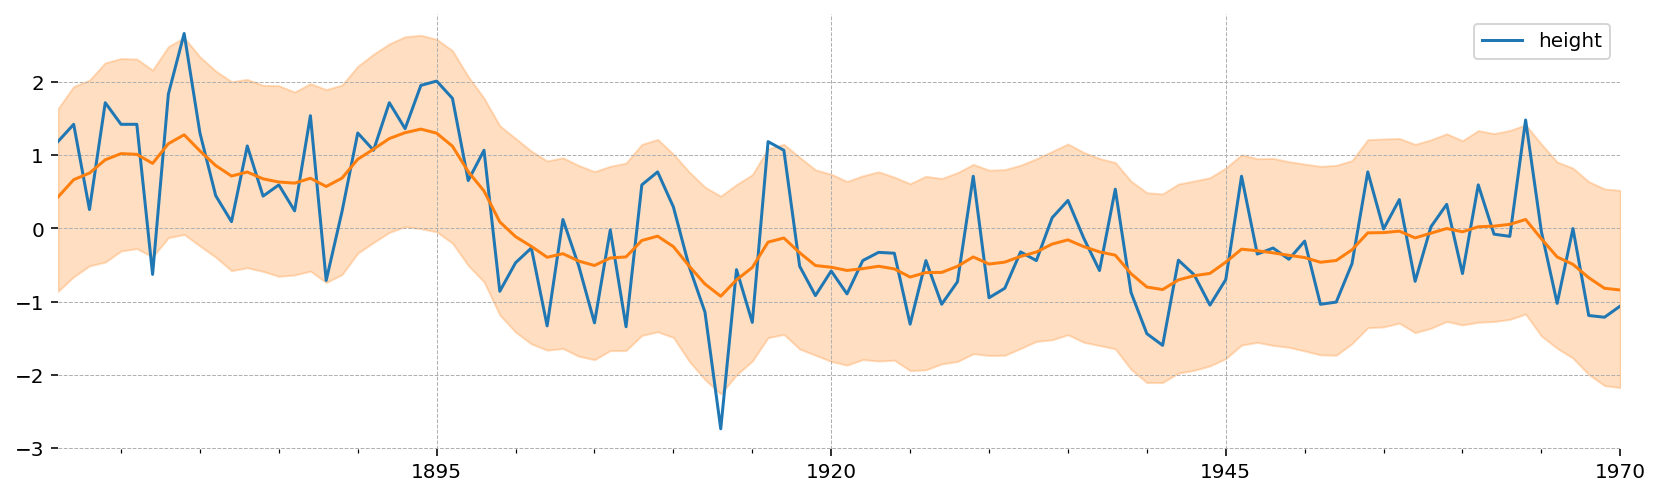

In [12]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
nile.plot(ax=ax)
pd.Series(grw_mu.values.ravel(), index=nile.index).plot(ax=ax)
ax.fill_between(x=nile.index, y1=ci_05, y2=ci_95, color="tab:orange", alpha=0.25)
plt.show()

## PyMC StateSpace Implementation

In [13]:
import pymc_statespace as pmss

state_space_model = pmss.BayesianLocalLevel(data=nile.values)

### Model

In [14]:
coords = {"time": nile.index.year.values, "states": ["level", "trend"], "obs": ["nile"]}

with pm.Model(coords=coords) as nile_model:
    state_sigmas = pm.HalfNormal("sigma_state", sigma=1.0, dims=["states"])
    obs_sigma = pm.HalfNormal("sigma_obs", sigma=1.0)

    sigma_P0 = pm.InverseGamma("P0_diag", mu=1.0, sigma=10.0, dims=["states"])
    x0 = pm.Normal("x0", mu=0.0, sigma=1.0, dims=["states"])

    P0 = pm.Deterministic("P0", at.eye(2) * sigma_P0)  # Force intial off-diagonal terms to be zero
    state_space_model.build_statespace_graph()

### Priors

Like in the case of GPs, we can consider both an unconditional and a conditional output distribution. Helper functions in the PyMC Statespace `model` class help the user sample and plot one or the other.

#### Unconditional Prior

In [17]:
with nile_model:
    prior_simulated_states, _ = state_space_model.sample_unconditional_prior(
        n_steps=100, n_simulations=10, prior_samples=500
    )

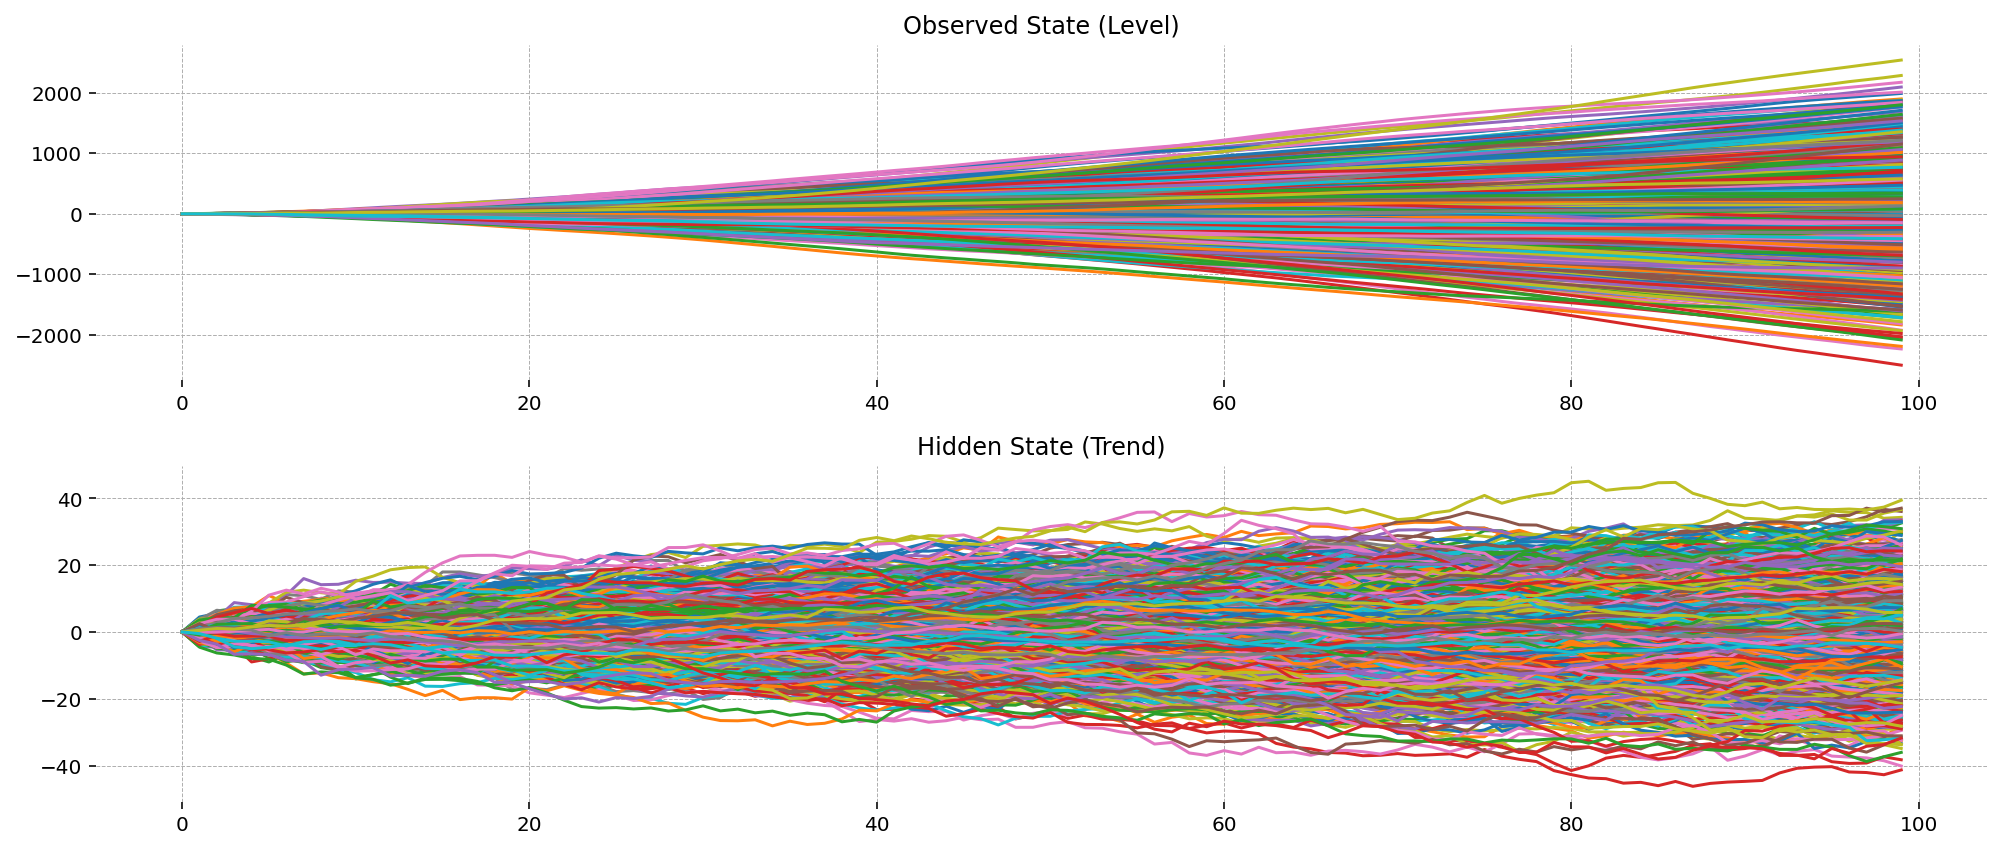

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(prior_simulated_states[:, :, idx].T)
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

#### Conditional Prior

The fit looks better than it is because the wide confidence intervals crush the means together. Up to +/- 4 standard deviations of variance of the trend is crazy 

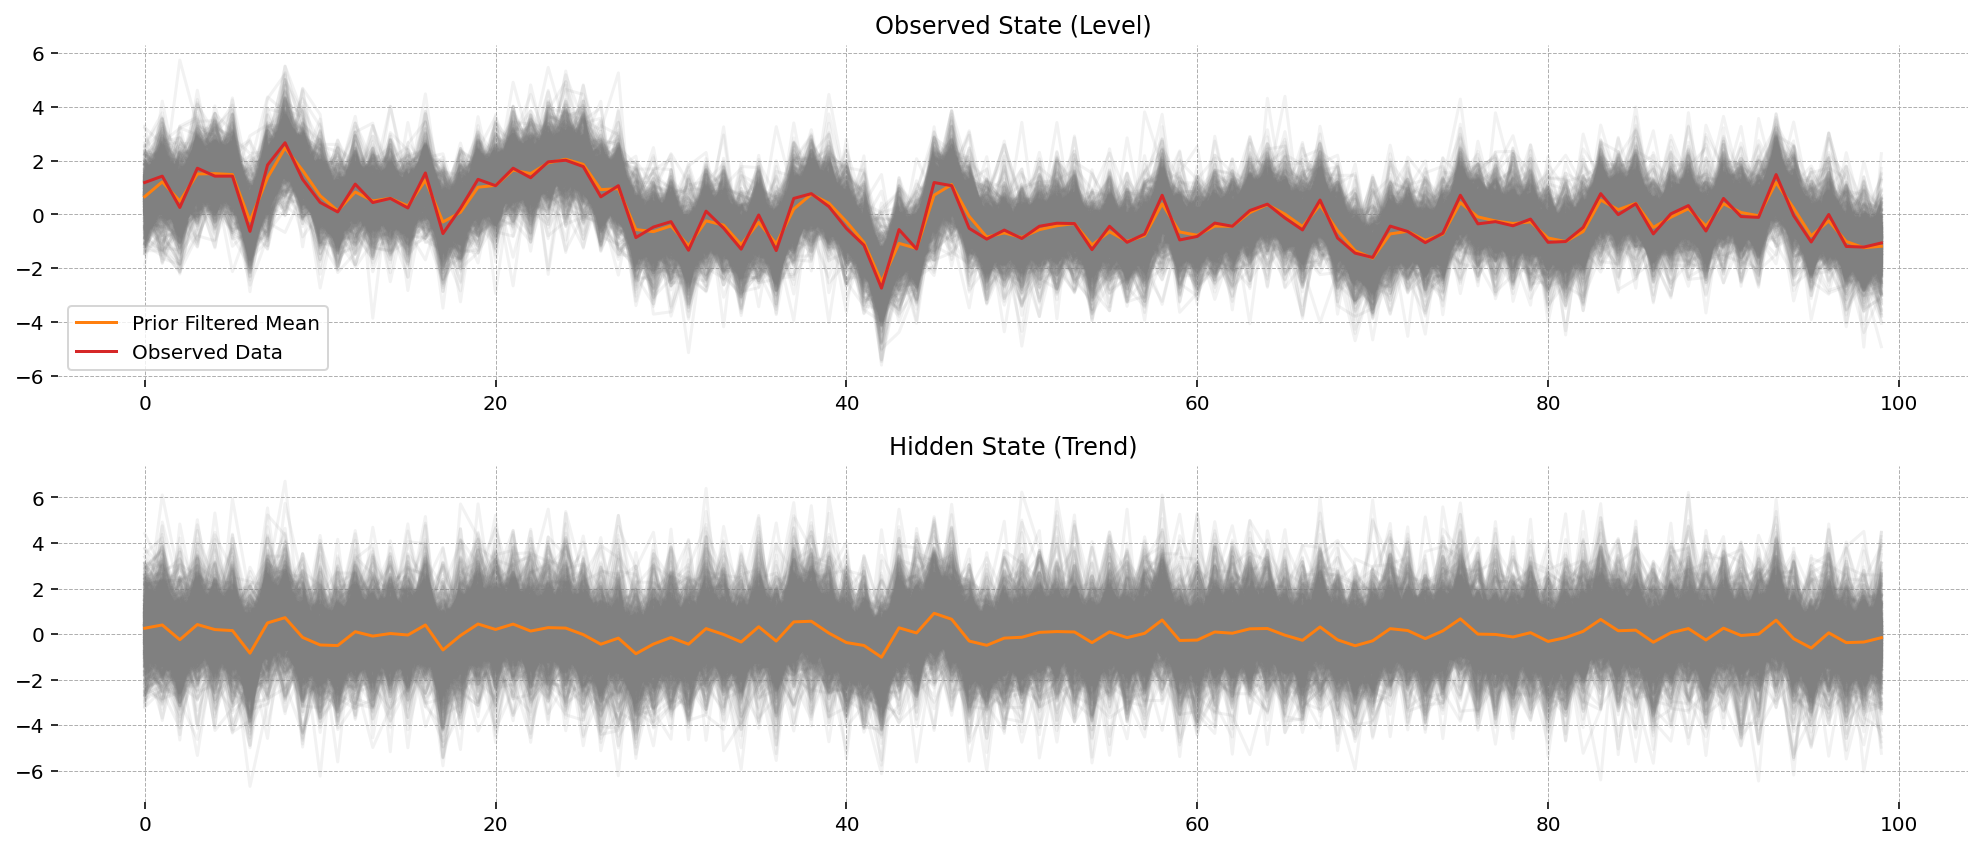

In [18]:
with nile_model:
    conditional_prior = state_space_model.sample_conditional_prior(
        n_simulations=10, filter_output="filtered"
    )

fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(conditional_prior[:, :, idx].T, color="0.5", alpha=0.1)
    axis.plot(
        conditional_prior[:, :, idx].mean(axis=0),
        color="tab:orange",
        label="Prior Filtered Mean",
    )
    if idx == 0:
        axis.plot(nile.values, color="tab:red", label="Observed Data")
    axis.set(title=name)

ax[0].legend()
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

In [19]:
with nile_model:
    kalman_trace = pm.sample(cores=6, target_accept=0.9, init="jitter+adapt_diag_grad")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_state, sigma_obs, P0_diag, x0]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 508 seconds.


### Posterior

In [20]:
az.summary(kalman_trace, var_names=["x0", "sigma_state", "sigma_obs", "P0_diag"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
x0[level]           0.651  0.696  -0.723    1.881      0.008    0.007   
x0[trend]          -0.017  0.619  -1.196    1.155      0.007    0.009   
sigma_state[level]  0.134  0.088   0.001    0.296      0.001    0.001   
sigma_state[trend]  0.001  0.002   0.000    0.005      0.000    0.000   
sigma_obs           0.478  0.108   0.282    0.681      0.002    0.001   
P0_diag[level]      0.889  1.281   0.103    2.224      0.023    0.016   
P0_diag[trend]      0.795  1.067   0.104    1.951      0.021    0.016   

                    ess_bulk  ess_tail  r_hat  
x0[level]             7552.0    4076.0    1.0  
x0[trend]             7512.0    3947.0    1.0  
sigma_state[level]    3819.0    2810.0    1.0  
sigma_state[trend]    8017.0    3860.0    1.0  
sigma_obs             4546.0    4281.0    1.0  
P0_diag[level]        5904.0    3771.0    1.0  
P0_diag[trend]        6136.0    3468.0    1.0

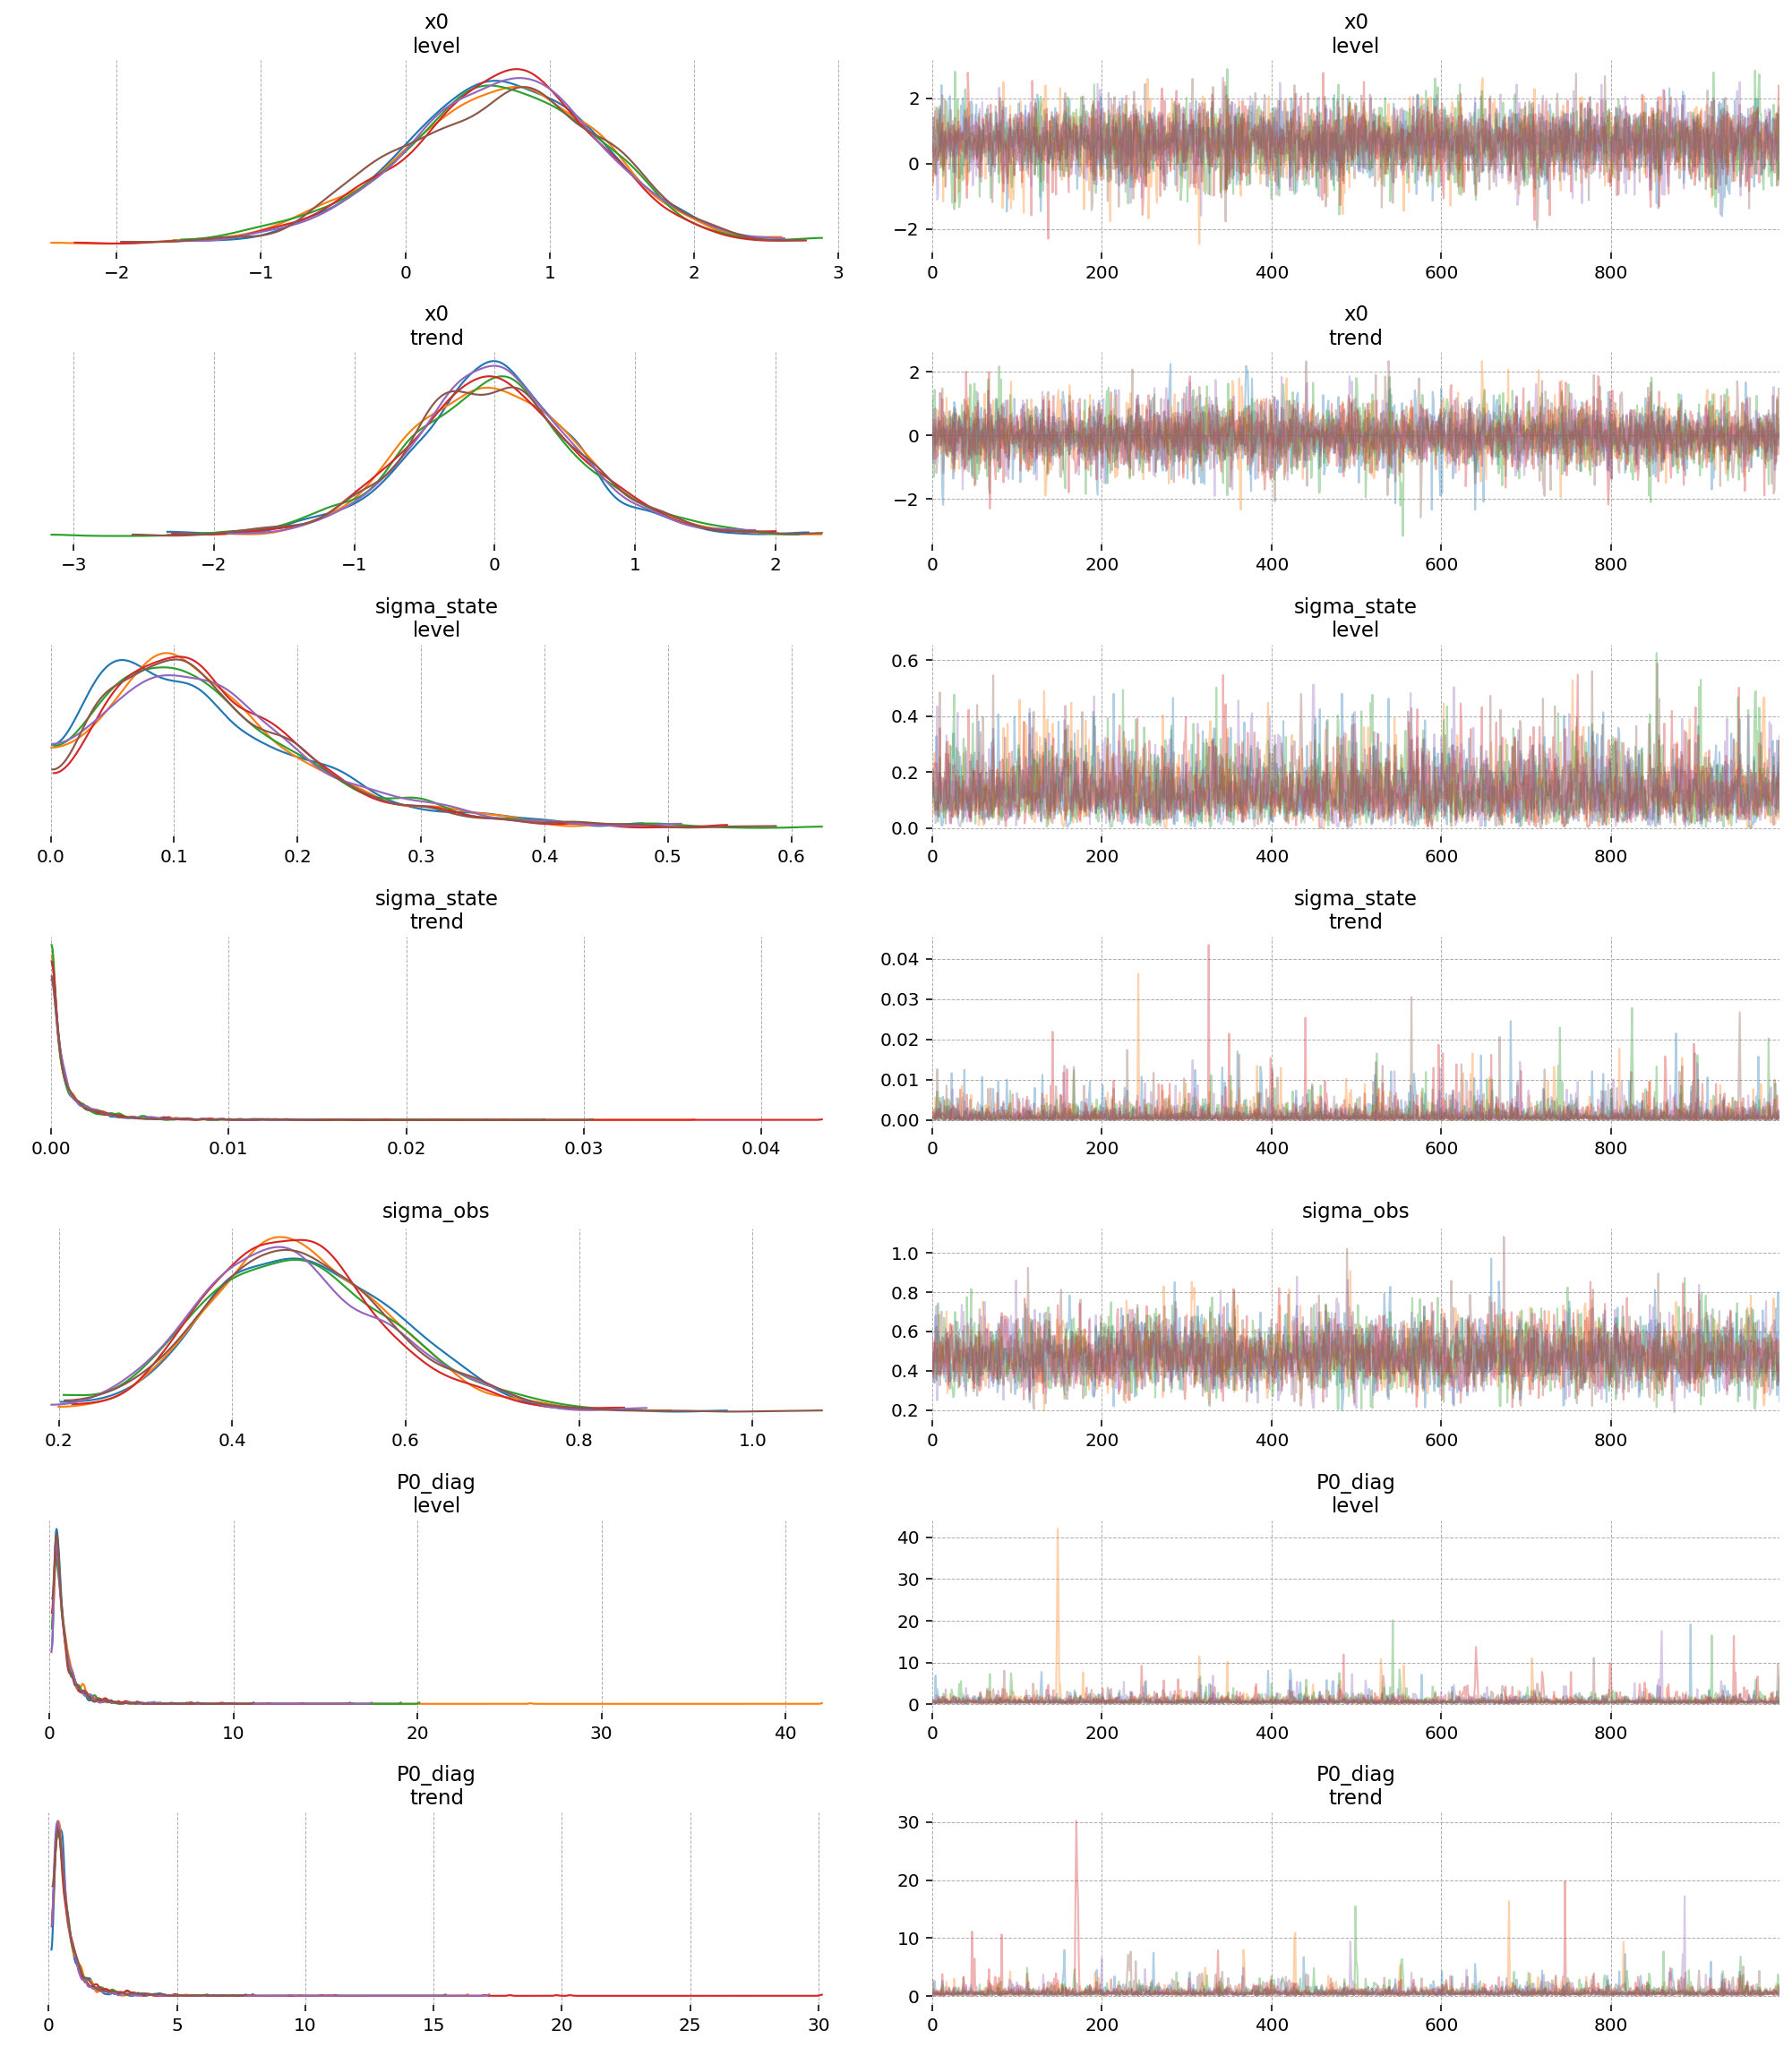

In [21]:
fig, ax = plt.subplots(7, 2, figsize=(14, 16), dpi=144)
az.plot_trace(
    kalman_trace,
    var_names=["x0", "sigma_state", "sigma_obs", "P0_diag"],
    compact=False,
    axes=ax,
)
fig.tight_layout()
plt.show()

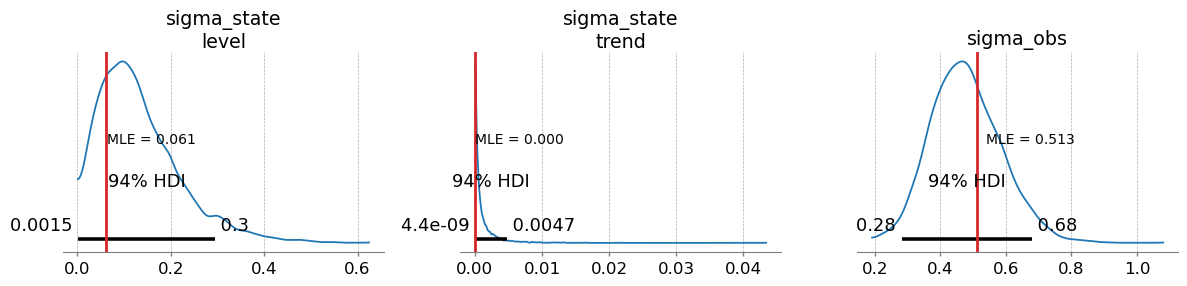

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
az.plot_posterior(
    kalman_trace,
    var_names=["sigma_state", "sigma_obs"],
    ax=ax,
    textsize=12,
    point_estimate=None,
)
params = ["sigma2.level", "sigma2.trend", "sigma2.measurement"]

for axis, name in zip(fig.axes, params):
    axis.axvline(res.params[name], color="tab:red", lw=2)
    ymin, ymax = axis.get_ylim()
    midpoint = (ymax - ymin) / 2
    axis.annotate(xy=(res.params[name] * 1.05, midpoint), text=f"MLE = {res.params[name]:0.3f}")

fig.set(facecolor="white")
fig.tight_layout()
plt.show()

#### Conditional Posterior

##### Filtered States

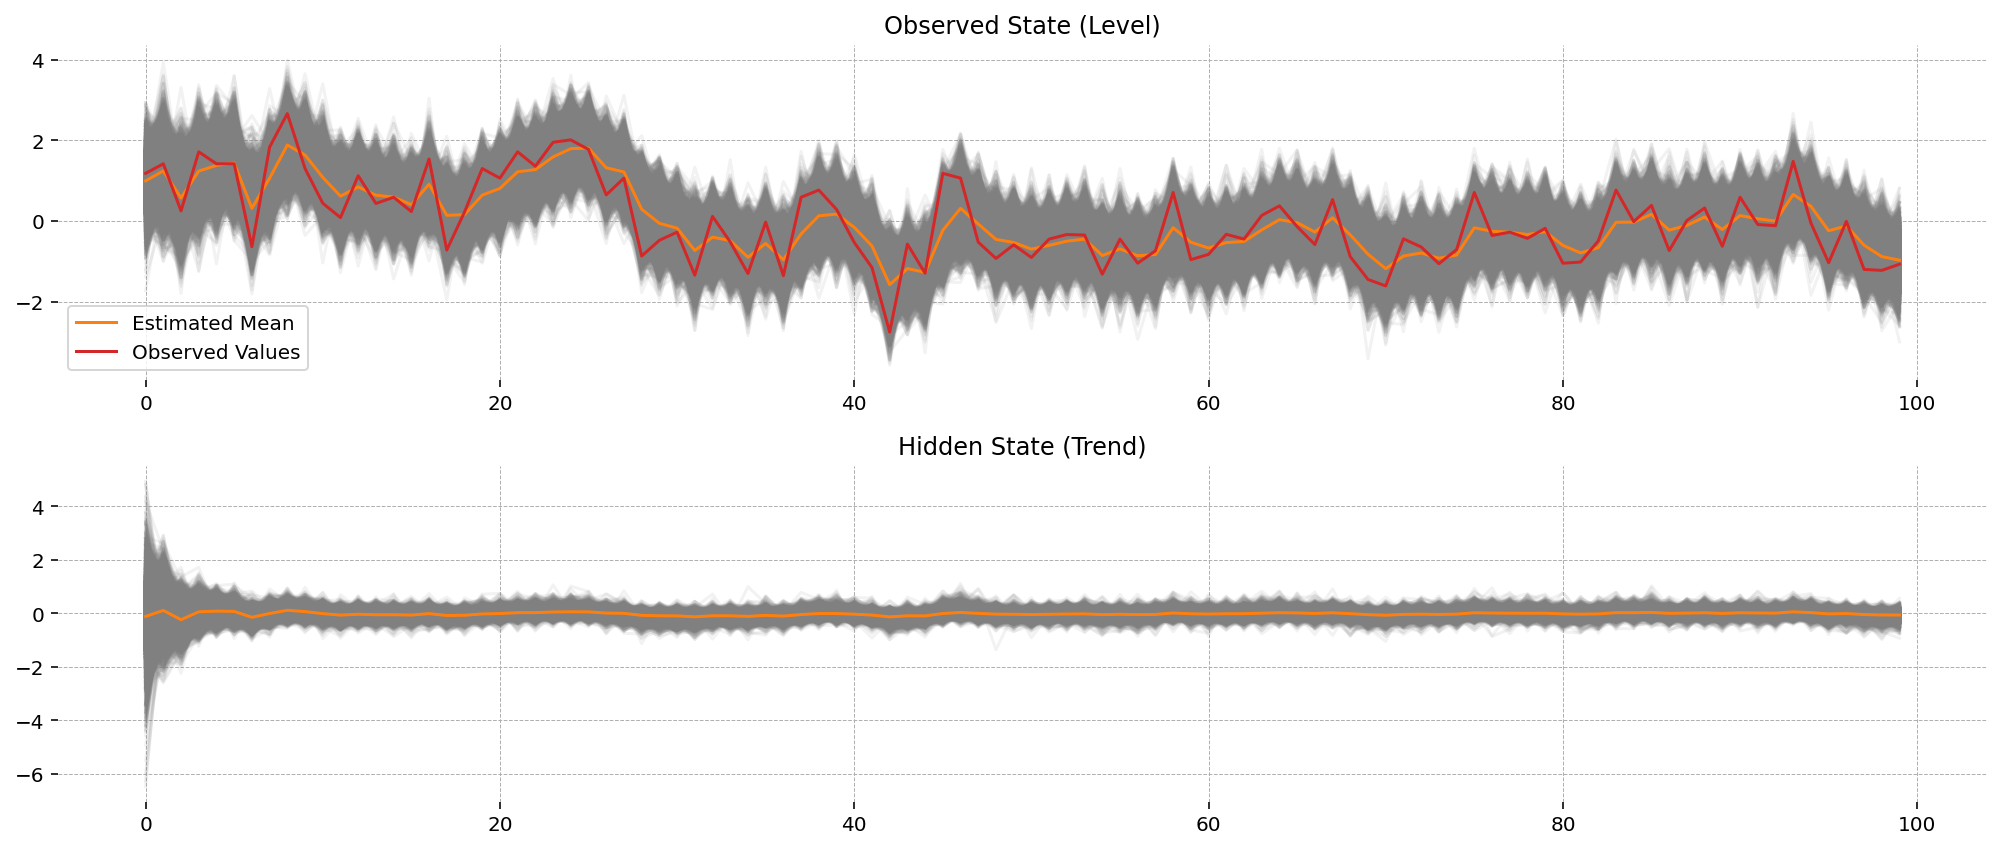

In [23]:
conditional_posterior = state_space_model.sample_conditional_posterior(
    kalman_trace, filter_output="filtered"
)
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(conditional_posterior[:, :, idx].T, color="0.5", alpha=0.1)
    axis.plot(
        conditional_posterior[:, :, idx].mean(axis=0),
        color="tab:orange",
        label="Estimated Mean",
    )
    if idx == 0:
        axis.plot(nile.values, color="tab:red", label="Observed Values")
    axis.set(title=name)

ax[0].legend()
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

##### Smoothed States

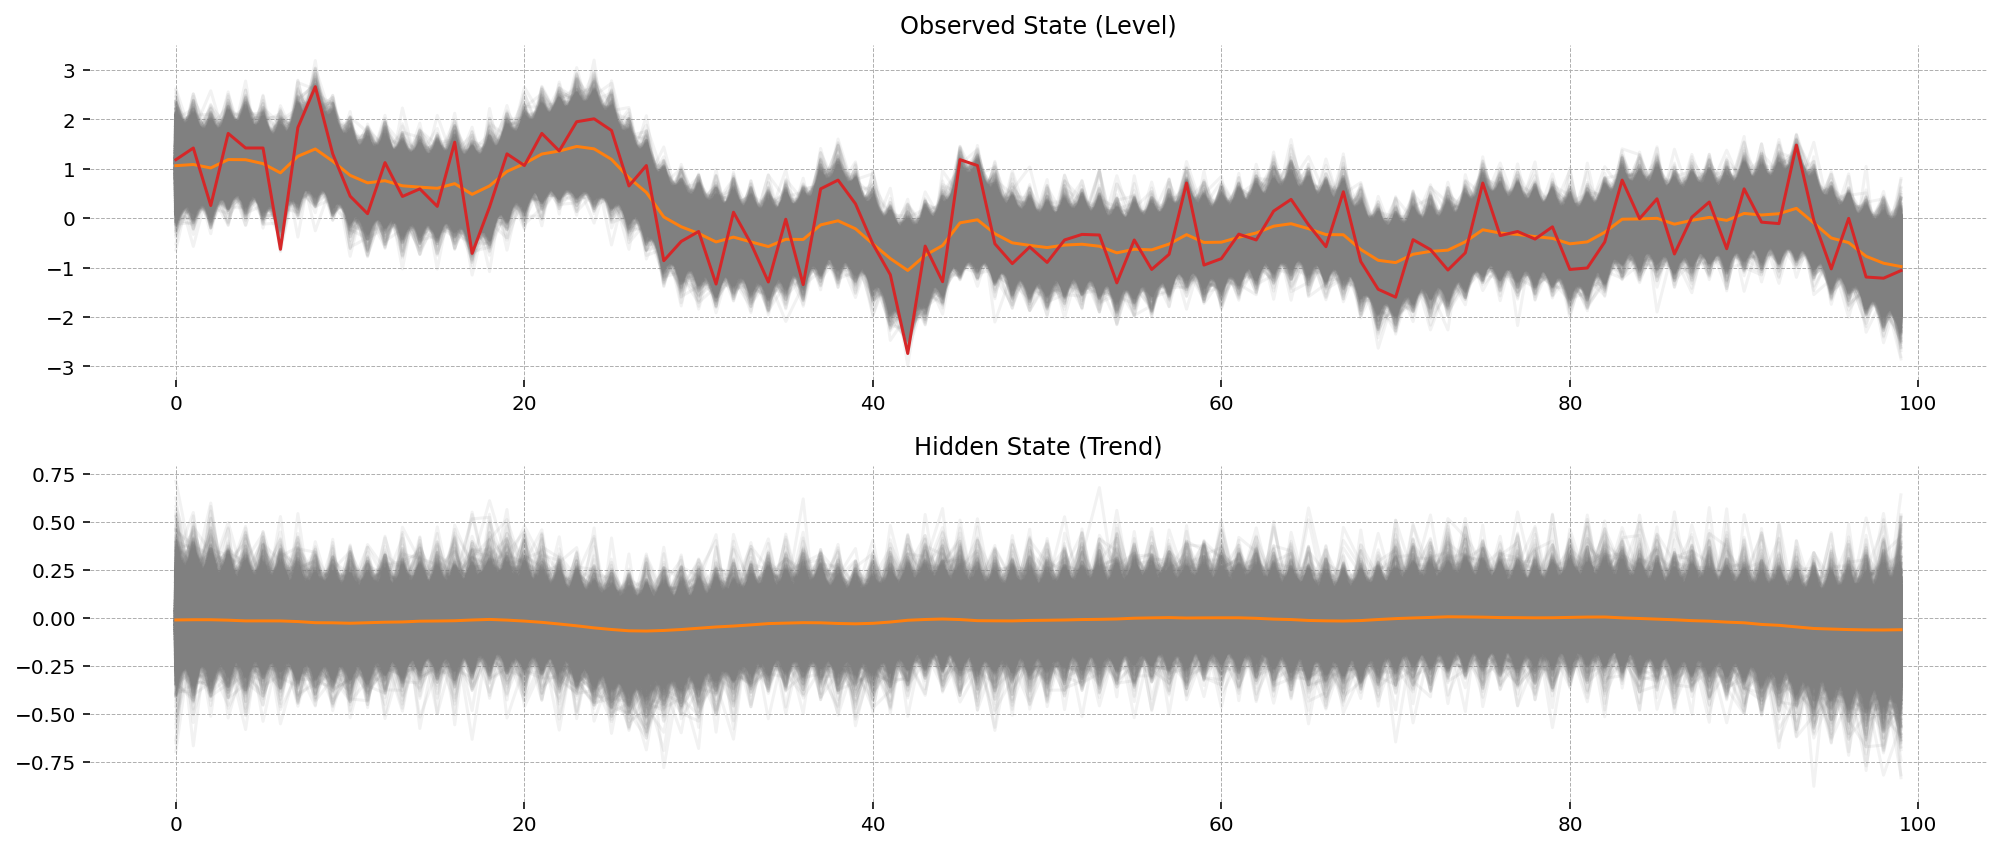

In [24]:
conditional_posterior = state_space_model.sample_conditional_posterior(
    kalman_trace, filter_output="smoothed"
)
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(conditional_posterior[:, :, idx].T, color="0.5", alpha=0.1)
    axis.plot(
        conditional_posterior[:, :, idx].mean(axis=0),
        color="tab:orange",
        label="Estimated Mean",
    )
    if idx == 0:
        axis.plot(nile.values, color="tab:red")
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

#### Unconditional Posterior

Unconditional dynamics are still not much to look at, but the "fanning" in the level has reduced a lot. If we put a dogmatic prior that the initial trend state is always zero the might look nicer, or if there were some covariance between the initial trend and level states.

I mean the bottom line is that this isn't exactly a sophisticated model; it is what it is.

In [25]:
with nile_model:
    posterior_state_sims, _ = state_space_model.sample_unconditional_posterior(
        kalman_trace, n_steps=100, n_simulations=10, posterior_samples=1000
    )

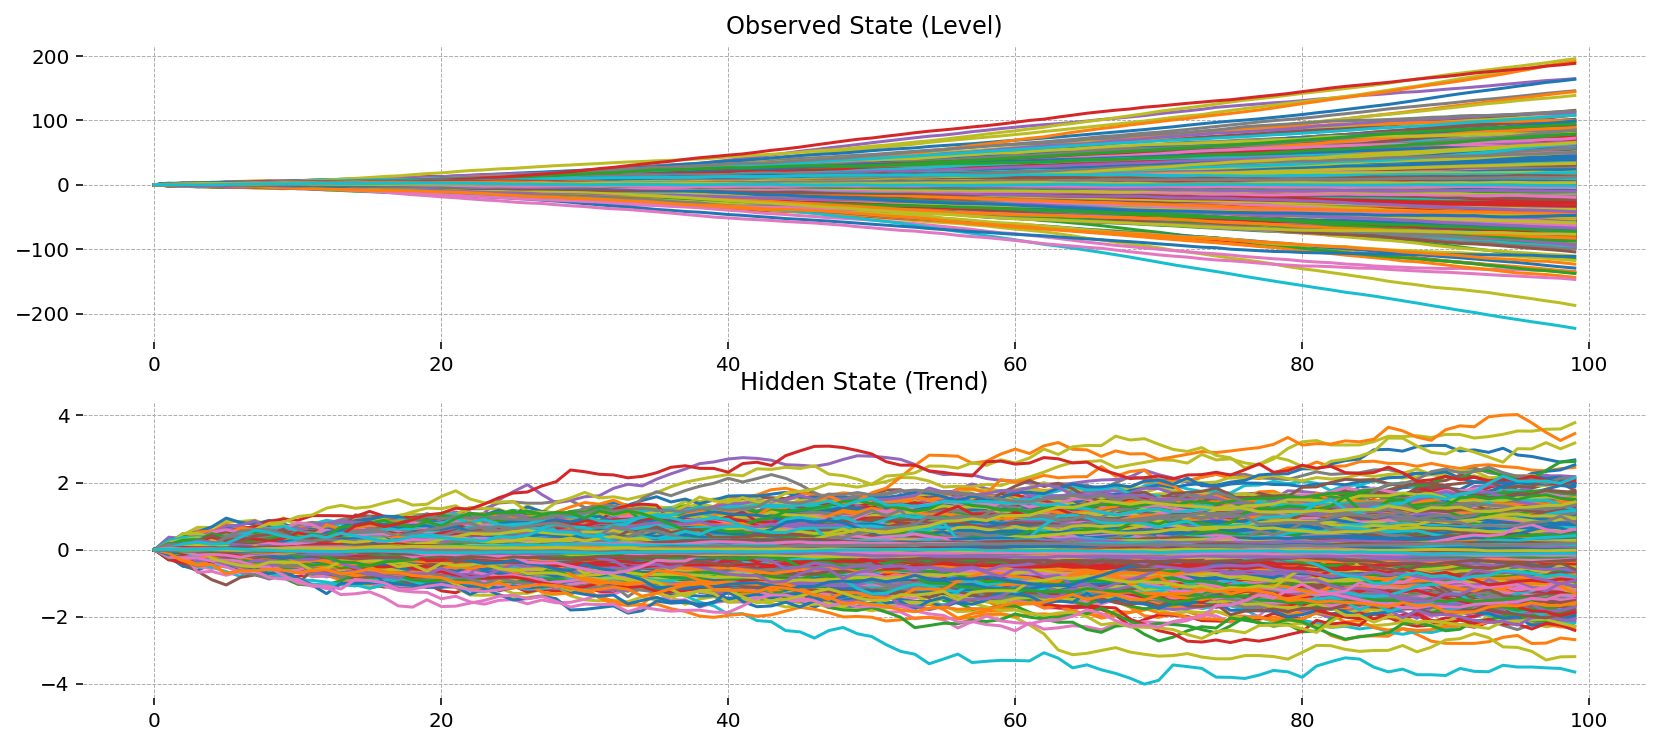

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Level)", "Hidden State (Trend)"])
):
    axis.plot(posterior_state_sims[:, :, idx].T)
    axis.set(title=name)

## Outputs Compared

In [27]:
az.summary(kalman_trace, var_names=["sigma_state", "sigma_obs", "x0", "P0_diag"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_state[level]  0.134  0.088   0.001    0.296      0.001    0.001   
sigma_state[trend]  0.001  0.002   0.000    0.005      0.000    0.000   
sigma_obs           0.478  0.108   0.282    0.681      0.002    0.001   
x0[level]           0.651  0.696  -0.723    1.881      0.008    0.007   
x0[trend]          -0.017  0.619  -1.196    1.155      0.007    0.009   
P0_diag[level]      0.889  1.281   0.103    2.224      0.023    0.016   
P0_diag[trend]      0.795  1.067   0.104    1.951      0.021    0.016   

                    ess_bulk  ess_tail  r_hat  
sigma_state[level]    3819.0    2810.0    1.0  
sigma_state[trend]    8017.0    3860.0    1.0  
sigma_obs             4546.0    4281.0    1.0  
x0[level]             7552.0    4076.0    1.0  
x0[trend]             7512.0    3947.0    1.0  
P0_diag[level]        5904.0    3771.0    1.0  
P0_diag[trend]        6136.0    3468.0    1.0

In [28]:
az.summary(grw_trace, var_names=["sigma_mu", "sigma_obs"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_mu   0.321  0.097   0.148    0.497      0.009    0.007     107.0   
sigma_obs  0.703  0.078   0.560    0.855      0.004    0.003     330.0   

           ess_tail  r_hat  
sigma_mu      382.0   1.04  
sigma_obs     870.0   1.02

In [29]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:               LocalLinearTrend   Log Likelihood                -142.664
Date:                Sat, 11 Jun 2022   AIC                            291.329
Time:                        20:52:02   BIC                            299.144
Sample:                    01-01-1871   HQIC                           294.492
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level           0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend        1.085e-11      0.000   7.38e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.30   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                             0.05
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Smoother Outputs from all 3 models

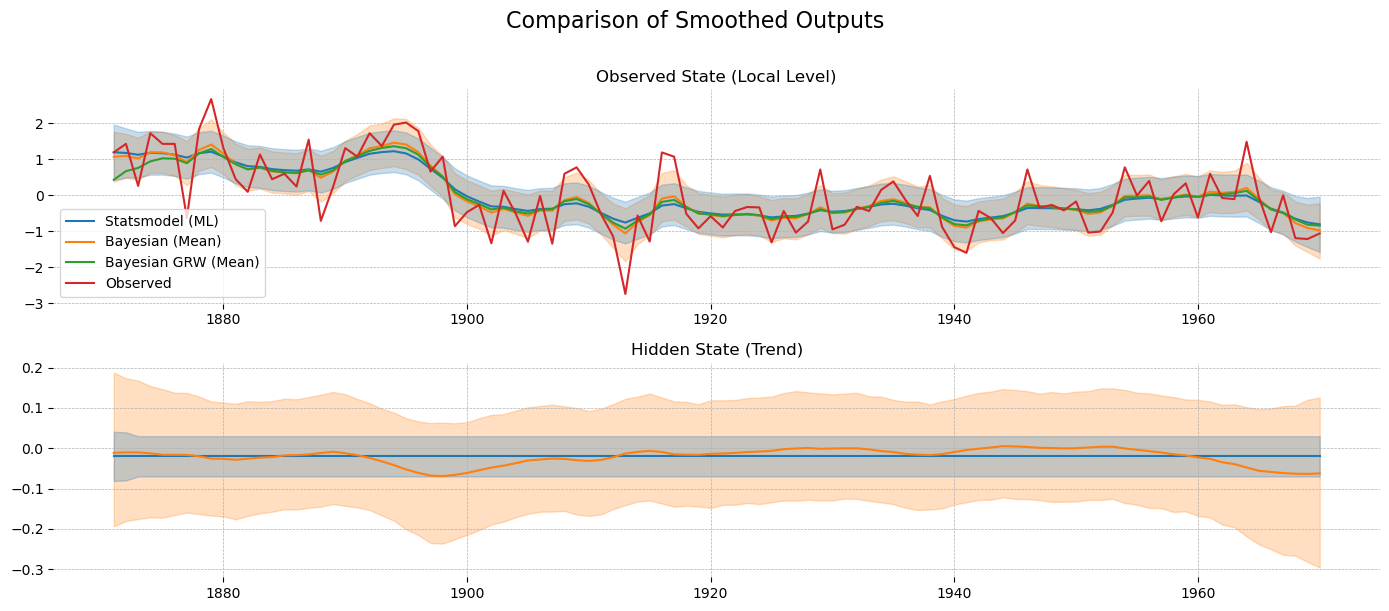

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=100)
x_values = nile.index

mu_pred_long = conditional_posterior.mean(axis=0)
grw_mu

ax[0].plot(nile.index, res.states.smoothed.iloc[:, 0], label="Statsmodel (ML)")
ax[0].plot(nile.index, mu_pred_long[:, 0], label="Bayesian (Mean)")
ax[0].plot(nile.index, grw_mu, label="Bayesian GRW (Mean)")

ax[0].fill_between(
    nile.index,
    np.quantile(conditional_posterior, 0.05, axis=0)[:, 0],
    np.quantile(conditional_posterior, 0.95, axis=0)[:, 0],
    alpha=0.25,
    color="tab:orange",
)

ax[0].fill_between(
    nile.index,
    res.states.smoothed.iloc[:, 0]
    - 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 0, 0]),
    res.states.smoothed.iloc[:, 0]
    + 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 0, 0]),
    alpha=0.25,
    color="tab:blue",
)

ax[0].plot(x_values, nile.values, label="Observed")
ax[0].set(title="Observed State (Local Level)")
ax[0].legend()

ax[1].plot(nile.index, res.states.smoothed.iloc[:, 1], label="Statsmodel (ML)")
ax[1].plot(nile.index, mu_pred_long[:, 1], label="Bayesian (Mean)")
ax[1].fill_between(
    nile.index,
    np.quantile(conditional_posterior, 0.05, axis=0)[:, 1],
    np.quantile(conditional_posterior, 0.95, axis=0)[:, 1],
    alpha=0.25,
    color="tab:orange",
)

ax[1].fill_between(
    nile.index,
    res.states.smoothed.iloc[:, 1]
    - 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 1, 1]),
    res.states.smoothed.iloc[:, 1]
    + 1.96 * np.sqrt(res.states.smoothed_cov.values.reshape(-1, 2, 2)[:, 1, 1]),
    alpha=0.25,
    color="tab:blue",
)


ax[1].set(title="Hidden State (Trend)")
# ax[1].legend()
fig.suptitle("Comparison of Smoothed Outputs", y=1.01, size=16)
fig.set(facecolor="white")
fig.tight_layout()
plt.show()